In [ ]:
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Basic libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed  # If using threaded image loading

# Preprocessing and training
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Model components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score


Prepare Data

In [63]:
def display(img, title=''):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

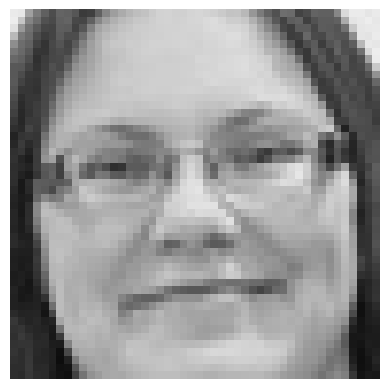

In [64]:
img = cv2.imread('/kaggle/input/fer2013/train//happy/Training_1206.jpg')
display(img)

In [ ]:
import os
import pandas as pd

train_data_path = '/kaggle/input/fer2013/train/'

# List all emotion folders inside train_data_path
emotion_folders = os.listdir(train_data_path)

image_paths = []
emotion_labels = []

for emotion in emotion_folders:
    emotion_folder_path = os.path.join(train_data_path, emotion)
    if not os.path.isdir(emotion_folder_path):
        continue
    # List images inside emotion folder
    images = os.listdir(emotion_folder_path)
    for img in images:
        image_paths.append(os.path.join(emotion_folder_path, img))
        emotion_labels.append(emotion)

# Create DataFrame
data = pd.DataFrame({
    'image_path': image_paths,
    'emotion': emotion_labels
})

print(data.head()) #show the first few file


                                          image_path   emotion
0  /kaggle/input/fer2013/train/surprise/Training_...  surprise
1  /kaggle/input/fer2013/train/surprise/Training_...  surprise
2  /kaggle/input/fer2013/train/surprise/Training_...  surprise
3  /kaggle/input/fer2013/train/surprise/Training_...  surprise
4  /kaggle/input/fer2013/train/surprise/Training_...  surprise




---
classify the emotion into 2 groups of satisfied(1) or unsatisfied(0)


check if the emotion mapping is correct 0= unsatisfied 1= satisfied

In [ ]:
import numpy as np
import cv2  # OpenCV for image loading/resizing
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(image_paths, img_size=(48,48)):
    images = []
    for path in image_paths:
        # Load grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # skip if image not found or corrupted
        # Resize to desired size
        img = cv2.resize(img, img_size)
        # Normalize pixel values to [0,1]
        img = img.astype('float32') / 255.0
        # Expand dims to add channel axis (48,48,1)
        img = np.expand_dims(img, axis=-1)
        images.append(img)
    return np.array(images)


In [39]:
# Define original emotion list as in your folders
emotion_labels_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprise']
label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels_list)}

# Map emotion names to indices
data['emotion_idx'] = data['emotion'].map(label_map)

# Map 7 emotions to 2 satisfaction classes
emotion_map = {
    0: 0,  # Angry
    1: 0,  # Disgust
    2: 0,  # Fear
    3: 1,  # Happy
    4: 0,  # Sad
    5: 1,  # Surprise
    6: 1   # Neutral
}

# Map to binary satisfaction labels
data['satisfaction'] = data['emotion_idx'].map(emotion_map)

# One-hot encode satisfaction labels
from tensorflow.keras.utils import to_categorical

labels = to_categorical(data['satisfaction'].values, num_classes=2)
X_train = load_and_preprocess_images(data['image_path'].values)
y_train = to_categorical(data['satisfaction'].values, num_classes=2)

print(data[['emotion', 'emotion_idx', 'satisfaction']].tail(10))
print(data[['emotion', 'emotion_idx', 'satisfaction']].tail(10))

      emotion  emotion_idx  satisfaction
28699   happy            3             1
28700   happy            3             1
28701   happy            3             1
28702   happy            3             1
28703   happy            3             1
28704   happy            3             1
28705   happy            3             1
28706   happy            3             1
28707   happy            3             1
28708   happy            3             1
      emotion  emotion_idx  satisfaction
28699   happy            3             1
28700   happy            3             1
28701   happy            3             1
28702   happy            3             1
28703   happy            3             1
28704   happy            3             1
28705   happy            3             1
28706   happy            3             1
28707   happy            3             1
28708   happy            3             1


In [40]:
# Check mapping for a specific emotion
for emotion in ['happy', 'sad', 'neutral', 'angry','surprise','fear']:
    idx = label_map[emotion]
    satisfaction = emotion_map[idx]
    print(f"Emotion: {emotion}, Index: {idx}, Satisfaction: {satisfaction}")


Emotion: happy, Index: 3, Satisfaction: 1
Emotion: sad, Index: 4, Satisfaction: 0
Emotion: neutral, Index: 5, Satisfaction: 1
Emotion: angry, Index: 0, Satisfaction: 0
Emotion: surprise, Index: 6, Satisfaction: 1
Emotion: fear, Index: 2, Satisfaction: 0


plot for the number of dataset that is satisfies and unsatisfied

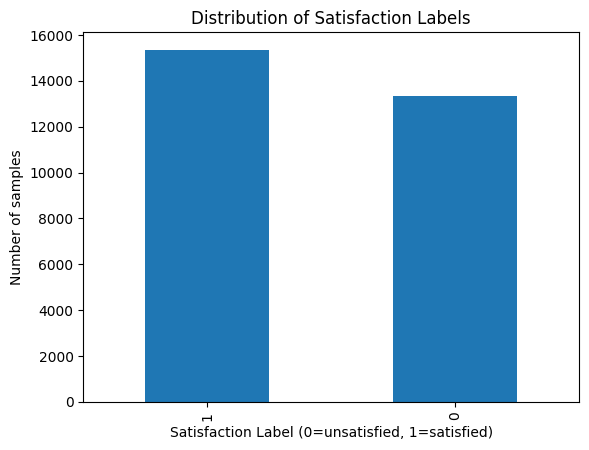

In [41]:
import matplotlib.pyplot as plt

data['satisfaction'].value_counts().plot(kind='bar')
plt.xlabel('Satisfaction Label (0=unsatisfied, 1=satisfied)')
plt.ylabel('Number of samples')
plt.title('Distribution of Satisfaction Labels')
plt.show()


In [46]:
# Assuming 'data' DataFrame with columns 'image_path' and 'satisfaction' (0 or 1)

# Load and preprocess all training images (this may take a while)
train_images = load_and_preprocess_images(data['image_path'].values)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(data['satisfaction'].values, num_classes=2)

# Split into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: satisfied / unsatisfied
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 838,402 (3.20 MB)

 Trainable params: 838,402 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [48]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.5548 - loss: 0.6856 - val_accuracy: 0.6092 - val_loss: 0.6526
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 86s 175ms/step - accuracy: 0.6327 - loss: 0.6359 - val_accuracy: 0.6404 - val_loss: 0.6353
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - accuracy: 0.6651 - loss: 0.6059 - val_accuracy: 0.6724 - val_loss: 0.6067
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 80s 166ms/step - accuracy: 0.7008 - loss: 0.5647 - val_accuracy: 0.6905 - val_loss: 0.5767
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 83s 170ms/step - accuracy: 0.7222 - loss: 0.5407 - val_accuracy: 0.7034 - val_loss: 0.5581
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 80s 165ms/step - accuracy: 0.7384 - loss: 0.5152 - val_accuracy: 0.7079 - val_loss: 0.5482
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.7567 - loss: 0.4940 - val_accuracy: 0.7135 - val_loss: 0.5442
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 84s 166ms/step - accuracy: 0.7769 - loss: 0

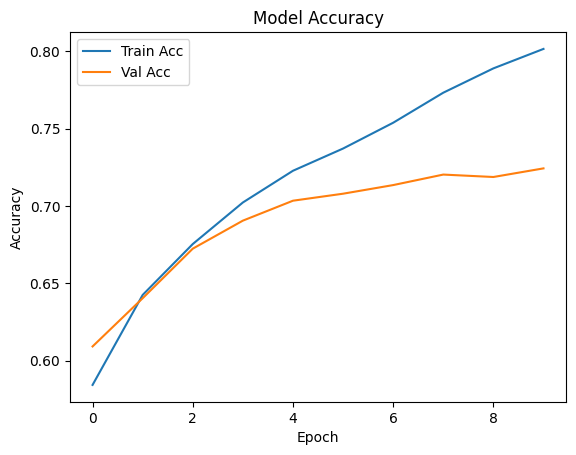

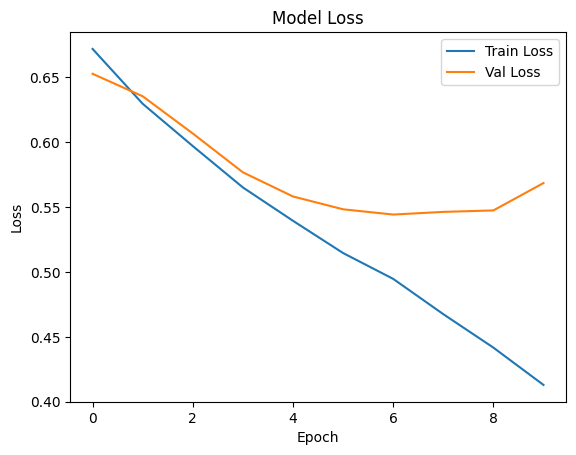

In [49]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


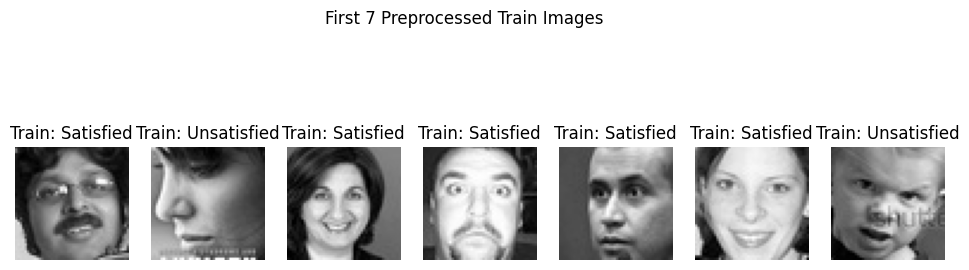

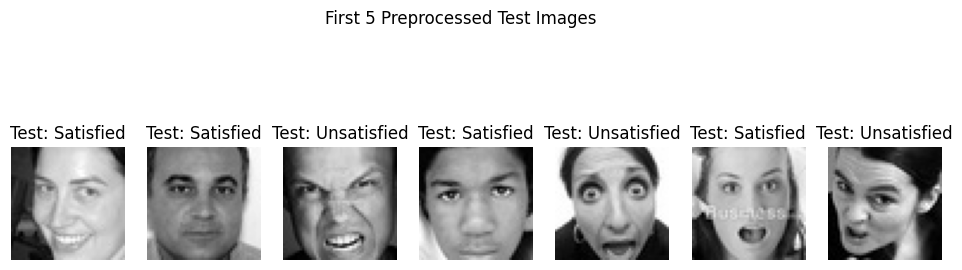

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Show first 5 preprocessed train images
plt.figure(figsize=(12, 4))
for i in range(7): #change number here if want to increase or decrease the images
    plt.subplot(1, 7, i + 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    label = np.argmax(y_train[i])  # convert one-hot to 0 or 1
    plt.title(f"Train: {'Satisfied' if label == 1 else 'Unsatisfied'}")
    plt.axis('off')
plt.suptitle("First 7 Preprocessed Train Images")
plt.show()

# Show first 5 preprocessed test images
plt.figure(figsize=(12, 4))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    label = np.argmax(y_test[i])  # convert one-hot to 0 or 1
    plt.title(f"Test: {'Satisfied' if label == 1 else 'Unsatisfied'}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Test Images")
plt.show()


Saving Training_170069.jpg to Training_170069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


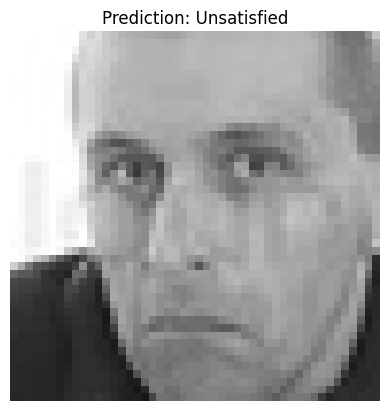

In [65]:
from google.colab import files
uploaded = files.upload()  # This will open a file chooser

# Get the uploaded file path
import io
from PIL import Image
import cv2
import numpy as np

# Assuming only one file was uploaded
image_path = list(uploaded.keys())[0]
def preprocess_single_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized.astype('float32') / 255.0
    expanded = np.expand_dims(normalized, axis=-1)  # (48,48,1)
    batch = np.expand_dims(expanded, axis=0)        # (1,48,48,1)
    return batch, img

image_array, original_image = preprocess_single_image(image_path)
prediction = model.predict(image_array)
predicted_label = np.argmax(prediction)
label_name = 'Satisfied' if predicted_label == 1 else 'Unsatisfied'

# Display result
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {label_name}")
plt.axis('off')
plt.show()


Saving test_happy.jpg to test_happy (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


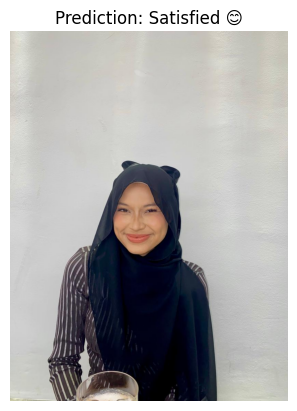

In [66]:
from google.colab import files
uploaded = files.upload()

# Get the image file name
image_path = list(uploaded.keys())[0]
import cv2
import numpy as np

def detect_and_preprocess_face(image_path):
    # Load and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect face
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected.")
        return None, img

    # Crop to first detected face
    (x, y, w, h) = faces[0]
    face = gray[y:y+h, x:x+w]

    # Resize and normalize
    face_resized = cv2.resize(face, (48, 48))
    face_normalized = face_resized.astype('float32') / 255.0
    face_expanded = np.expand_dims(face_normalized, axis=-1)  # shape (48, 48, 1)
    face_batch = np.expand_dims(face_expanded, axis=0)        # shape (1, 48, 48, 1)

    return face_batch, img
import matplotlib.pyplot as plt

# Use the function
input_image, original_img = detect_and_preprocess_face(image_path)

if input_image is not None:
    prediction = model.predict(input_image)
    predicted_class = np.argmax(prediction)
    label = "Satisfied 😊" if predicted_class == 1 else "Unsatisfied 😐"

    # Show result
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()


In [ ]:
train_data_path = '/kaggle/input/fer2013/train/'
test_data_path = '/kaggle/input/fer2013/test/'